In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import re
import pynlpir
pynlpir.open()
from sklearn import metrics
from scipy import stats
import scipy as sp

from helpers import *
from generate import *
from diagnostic import *

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

# Analysis on linux source code language model

### Import model

In [2]:
model_lstm = torch.load('models/linux_3x512_0d3_lstm_200l_40000E.model').cuda()
model_gru = torch.load('models/linux_3x512_0d3_gru_200l_40000E.model').cuda()
print('Perplexity LSTM:', 2**np.mean([test_model(model_lstm, 'data/linux/test.txt') for _ in range(1)]))
print('Perplexity GRU: ', 2**np.mean([test_model(model_gru, 'data/linux/test.txt') for _ in range(1)]))

Perplexity LSTM: 2.18350716101
Perplexity GRU:  2.29313456059


### Generate text

In [3]:
print('\n============== LSTM MODEL ==============\n')
text, hiddens = generate(model_lstm, '\n\n', 500, 0.8, True)
print(text)

print('\n============== GRU MODEL ===============\n')
text, hiddens = generate(model_gru, '\n\n', 500, 0.8, True)
print(text)


============== LSTM MODEL ==============

struct intel_gpio_ctrl {
	unsigned long flags;
	struct gpio_dev *gspi = &fsm_gpio_get_gpio_desc(althatout);
	unsigned long flags = 0;

	data = av_voltage_gpio;

	ctrls->gfx = cpu_to_be32(0x72);
	REG_FUNCTION(0xc, "gpio-fmc0", 0, RT8769_OFFSET_4_MASK),
		V4L2_CID_BANK_FIELD(VI4_F12, VV03AD_REG_CTRL_VSYNC_NUM_B, 7);
	VGA_DS1680(VGA_VALUE_TO_LDON, vlan_vbase);
#endif
}

static void card9970_write(void *arg)
{
	struct v4l2_subdev *sd = v4l2_get_drvdata(chip->drvdata);
	struct v4l2_subdev *sd = &vga-

============== GRU MODEL ===============

static int clock_device_clk_disable(struct unarchdev_int *advh,
				 u32 active_segment)
{
	struct intel_enqueue *adapter;
	struct irq_data *data = dev_get_drvdata(dev);
	struct max3990_device *dev = adapter->hw;
	int ret;

	ret = 0;

	if (regs->config == LXCHIP_DATA_IRQ_MASK)
		return;

	cs_scan_channel(chip->chip_ade);
	dcbx_write(client, mcrs, DC_8XX_COMMATE_DIT, map, &clk);

	/*
	 * Locking must be send be

### Define Code Hypotheses

In [7]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_inside_one(text, single):
    hyp = re.sub('\{}.*?\{}'.format(single, single), lambda m: single+'#'*(len(m.group())-2)+single, text)
    return np.array([1 if x == '#' else -1 for x in hyp])

def hypothesis_inside_two(text, left, right):
    hyp = np.full(len(text), -1)
    inside = False
    for i in range(len(text) - 1):
        if text[i] == left:
            inside = True
        elif text[i] == right:
            inside = False
        if inside:
            hyp[i+1] = 1
    return hyp

hypothesis_inside_quotation = lambda x: hypothesis_inside_one(x, '"')
hypothesis_inside_parantheses = lambda x: hypothesis_inside_two(x, '(', ')')

def hypothesis_comments(text):
    hyp = np.full(len(text), -1)
    in_brac_comment = False
    in_line_comment = False
    for i in range(len(text)):
        if text[i:i+2] == '//':
            in_line_comment = True
        elif text[i] == '\n':
            in_line_comment = False
        elif text[i:i+2] == '/*':
            in_brac_comment = True
        elif text[i:i+2] == '*/':
            in_brac_comment = False
        if in_brac_comment:
            hyp[i:i+3] = 1
        if in_line_comment:
            hyp[i:i+1] = 1
    return hyp

def hypothesis_indentation(text, level):
    hyp = np.full(len(text), -1)
    cur_level = 0
    for i, char in enumerate(text):
        if char == '\n':
            cur_level = 0
        elif char == '\t':
            cur_level += 1
        if cur_level >= level:
            hyp[i] = 1
    return hyp
# plot_colored_text(text, hypothesis_inlinecounter(text), title='Hypothesis: Inline counter', save_file='plots/hyp_inline_counter.png')
# plot_colored_text(text, hypothesis_inside_quotation(text), title='Hypothesis: Inside quotation', save_file='plots/hyp_inside_quotation.png')
# plot_colored_text(text, hypothesis_inside_parantheses(text), title='Hypothesis: Inside parantheses', save_file='plots/hyp_inside_parantheses.png')
# plot_colored_text(text, hypothesis_comments(text), title='Hypothesis: Comments', save_file='plots/hyp_comments.png')
# plot_colored_text(text, hypothesis_indentation(text, 1), title='Hypothesis: Indent level 1', save_file='plots/hyp_indent_1.png')
# plot_colored_text(text, hypothesis_indentation(text, 2), title='Hypothesis: Indent level 2', save_file='plots/hyp_indent_2.png')
# plot_colored_text(text, hypothesis_indentation(text, 3), title='Hypothesis: Indent level 3', save_file='plots/hyp_indent_3.png')

### Validate hypotheses

In [15]:
def full_test(model, hypothesis, name, plot=False, train_len=95, test_len=10,
              ex_name='test'):
    y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis,
                                         train_len=train_len, test_len=train_len,
                                         save_hyp='plots/hyp_{}.png'.format(ex_name),
                                         save_diag='plots/diag_{}.png'.format(ex_name),
                                         save_resp='plots/resp_{}.png'.format(ex_name))
    metric_pearsonr = lambda a, b: stats.pearsonr(a, b)[0]
    
    print("Hypothesis: {} (normal)".format(name))
    print('acc:      ', metrics.accuracy_score(y_true, y_pred))
    print('prec:     ', metrics.precision_score(y_true, y_pred))
    print('recall:   ', metrics.recall_score(y_true, y_pred))
    print('f1-score: ', metrics.f1_score(y_true, y_pred))
    print('pearsonr: ', metric_pearsonr(y_true, y_pred))
    y_true, y_pred = validate_hypothesis(model, LogisticRegression(class_weight='balanced'),
                                         hypothesis, train_len=train_len, test_len=test_len,
                                         save_hyp='plots/hyp_{}_balanced.png'.format(ex_name),
                                         save_diag='plots/diag_{}_balanced.png'.format(ex_name),
                                         save_resp='plots/resp_{}_balanced.png'.format(ex_name))
    print("Hypothesis: {} (balanced)".format(name))
    print('acc:      ', metrics.accuracy_score(y_true, y_pred))
    print('prec:     ', metrics.precision_score(y_true, y_pred))
    print('recall:   ', metrics.recall_score(y_true, y_pred))
    print('f1-score: ', metrics.f1_score(y_true, y_pred))
    print('pearsonr: ', metric_pearsonr(y_true, y_pred))

In [ ]:
for model_name, model in [('linux_lstm', model_lstm), ('linux_gru', model_gru)]:
    print("MODEL: ", model_name)
    y_true, y_pred = validate_hypothesis(model, LinearRegression(), hypothesis_inlinecounter,
                                         train_len=95, test_len=1,
                                         save_hyp='plots/{}_hyp_inlinecounter.png'.format(model_name),
                                         save_diag='plots/{}_diag_inlinecounter.png'.format(model_name),
                                         save_resp='plots/{}_resp_inlinecounter.png'.format(model_name))

In [ ]:
for model_name, model in [('linux_lstm', model_lstm), ('linux_gru', model_gru)]:
    print("MODEL: ", model_name)
    full_test(model, hypothesis_inside_quotation, 'Inside Quotation',
              train_len=95, test_len=10, ex_name='inside_quotation'.format(model_name))
    full_test(model, hypothesis_comments, 'Comments',
              train_len=95, test_len=10, ex_name='{}_inside_comments'.format(model_name))
    full_test(model, lambda x: hypothesis_indentation(x, 1), 'Indentation level 1',
              train_len=95, test_len=10, ex_name='{}_inside_indent_1'.format(model_name))
    full_test(model, lambda x: hypothesis_indentation(x, 2), 'Indentation level 2',
              train_len=95, test_len=10, ex_name='{}_inside_indent_2'.format(model_name))
    full_test(model, lambda x: hypothesis_indentation(x, 3), 'Indentation level 3',
              train_len=95, test_len=10, ex_name='{}_inside_indent_3'.format(model_name))
    full_test(model, hypothesis_inside_parantheses, 'Inside Parantheses',
              train_len=95, test_len=10, ex_name='{}_inside_parantheses'.format(model_name))

MODEL:  linux_lstm


# Analysis on Shakespeare model 

### Load Shakespeare language odel

In [9]:
# model = torch.load('models/simple.model').cuda()
# print('Perplexity:', 2**np.mean([test_model(model, 'data/tiny-shakespeare/test.txt') for _ in range(1)]))
model_lstm = torch.load('models/shake_2x128_lstm_3000').cuda()
print('Perplexity:', 2**np.mean([test_model(model_lstm, 'data/tiny-shakespeare/test.txt') for _ in range(1)]))
model_gru = torch.load('models/shake_2x128_gru_3000').cuda()
print('Perplexity:', 2**np.mean([test_model(model_gru, 'data/tiny-shakespeare/test.txt') for _ in range(1)]))

Perplexity: 2.54972012882
Perplexity: 2.67940986205


### Generate text

In [10]:
print('\n============== LSTM MODEL ==============\n')
text, hiddens = generate(model_lstm, '\n\n', 500, 0.8, True)
print(text)

print('\n============== GRU MODEL ===============\n')
text, hiddens = generate(model_gru, '\n\n', 500, 0.8, True)
print(text)



============== LSTM MODEL ==============

First Citizen:
God tell them committon to the very more:
In think it is a stationous.

BUCKINGHAM:
What must thou think got unto do dosters
Shall past my body are to Barnard soul,
Say unpeal only not our power then seem my crease.
You know for him was a sons and payss apposed a like constants
Rivers are ages about the sons and not a thing,
To make madampts dose their supple are pardon'd Paulina bowers:
Her death that I seem us goes that I will may never
calls in thee sent her heart
Hath art thou

============== GRU MODEL ===============

LEONTES:
My lord,
Since, not a stones of question house of since.

KATHARINA:
The soon of the banion,
I will not wirst-windain'd the daoken most law.

DUCHESS OF YORK:
Had hill my throne, I have much; make hasting,
Have could turn you I to make you to reprock you in ha dion.

GLOUCESTER:
To charged me meot again with my son the
And lorce, pretty beilan which shame?

WARWICK:
Yet with his blood.

PAULINA:

Prov

### Define language hypotheses

In [12]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_capswords(text):
    hyp = np.concatenate([np.full(len(x)+1, 1) if re.sub('[^a-zA-Z]+', '', x).isupper() else np.full(len(x)+1, -1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_pos(text, pos_tag):
    hyp = text.replace('1', '0')
    for word, tag in pynlpir.segment(text):
        if tag == pos_tag:
            hyp = hyp.replace(word, '1'*len(word), 1)
        else:
            hyp = hyp.replace(word, '0'*len(word), 1)
    hyp = [1 if x=='1' else -1 for x in re.sub('[^1]', '0', hyp)]
    
    return hyp

def hypothesis_verbs(text):
    return hypothesis_pos(text, 'verb')

def hypothesis_nouns(text):
    return hypothesis_pos(text, 'noun')

In [5]:
# plot_colored_text(text, hypothesis_inlinecounter(text), title='Hypothesis: Inline Counter', save_file='plots/hyp_inlinecounter.png')
# plot_colored_text(text, hypothesis_capswords(text), title='Hypothesis: Capitalized Words', save_file='plots/hyp_capswords.png')
# plot_colored_text(text, hypothesis_verbs(text), title='Hypothesis: Verbs', save_file='plots/hyp_verbs')
# plot_colored_text(text, hypothesis_nouns(text), title='Hypothesis: Nouns', save_file='plots/hyp_nouns')

## Validate hypotheses

In [6]:
# Generate hypothesis data
def gen_hyp_data(model, N, text_len=500):
    texts, hiddens, hyps = [], [], []
    for i in range(N):
        text, hidden = generate(model, '\n\n', text_len, 0.8, True)
        hidden = hidden.reshape(hidden.shape[0], -1)
        hyp = hypothesis_inlinecounter(text)
        hiddens.append(hidden)
        hyps.append(hyp)
        texts.append(text)
    return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens)

# Generate train and test data
train_texts, train_hyps, train_hiddens = gen_hyp_data(model_gru, 500)
test_texts, test_hyps, test_hiddens = gen_hyp_data(model_gru, 2)

In [7]:
diag_classifier = LinearRegression()
# Train Diagnostic Classifier
diag_classifier.fit(train_hiddens, train_hyps)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
np.argsort(np.abs(diag_classifier.coef_))

In [ ]:
scipy.stats.pearsonr(x, y)

In [ ]:
# Find responsible neuron
resp_neuron = np.argmax(np.abs(diag_classifier.coef_))
print(resp_neuron)

In [ ]:
for i in np.argsort(np.abs(diag_classifier.coef_))[-10:]:
    plot_colored_text(train_texts[:500], train_hiddens[:500, i],
                      title='Most Responsible Neuron {}'.format(i),
                      save_file='plots/temp_{}.png'.format(i))


In [ ]:
for i in range(200):
    plot_colored_text(train_texts[:500], train_hiddens[:500, i],
                      title='Most Responsible Neuron {}'.format(i),
                      save_file='plots/temp_{}.png'.format(i))


In [ ]:
y_true, y_pred = validate_hypothesis(model, LinearRegression(), hypothesis_inlinecounter,
                                     train_len=95, test_len=5,
                                     save_hyp='plots/hyp_inlinecounter_shake.png',
                                     save_diag='plots/diag_inlinecounter_shake.png',
                                     save_resp='plots/resp_inlinecounter_shake.png')

MODEL:  linux_lstm
275


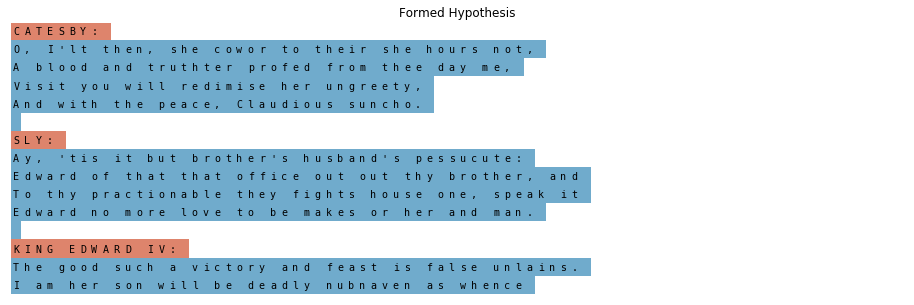

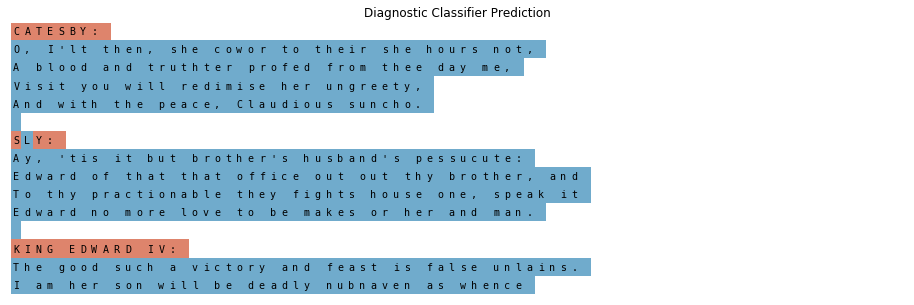

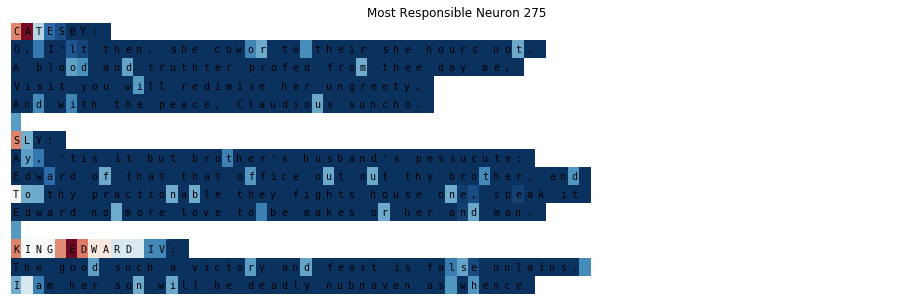

Hypothesis: Capitalized Words (normal)
acc:       0.996631578947
prec:      0.971698113208
recall:    0.986170212766
f1-score:  0.978880675818
pearsonr:  0.977082143408
345


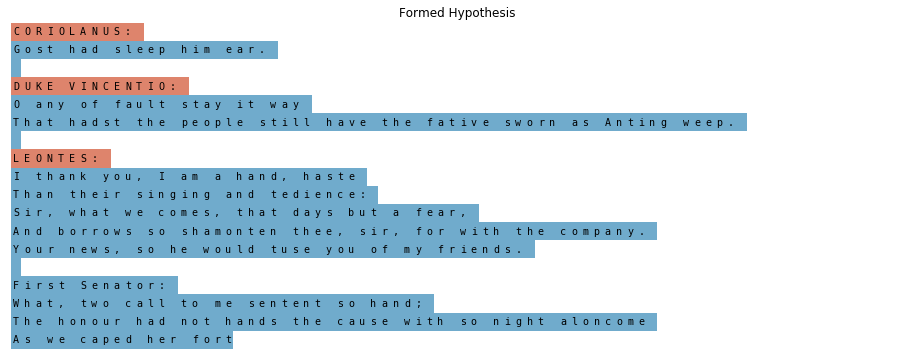

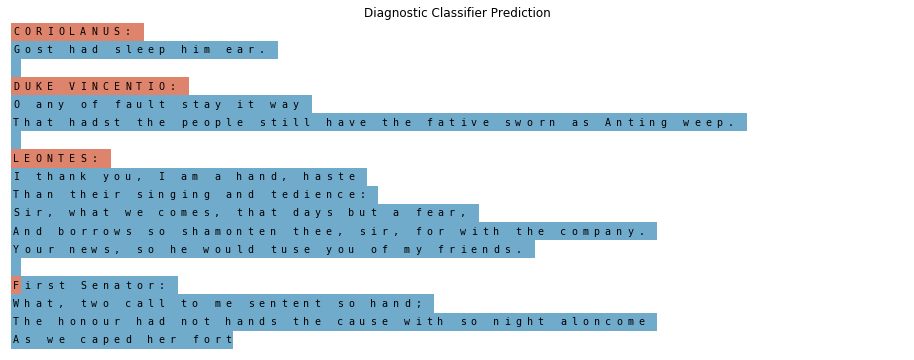

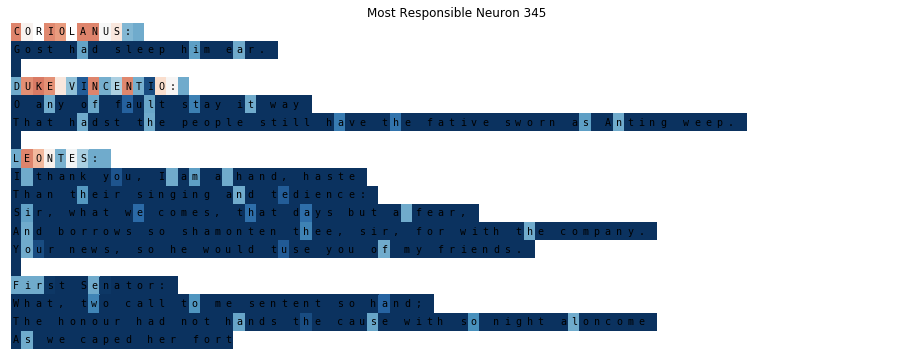

Hypothesis: Capitalized Words (balanced)
acc:       0.9936
prec:      0.899371069182
recall:    1.0
f1-score:  0.94701986755
pearsonr:  0.94512743975


part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'grjyy'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'grjyy'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'grjyy'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'


152


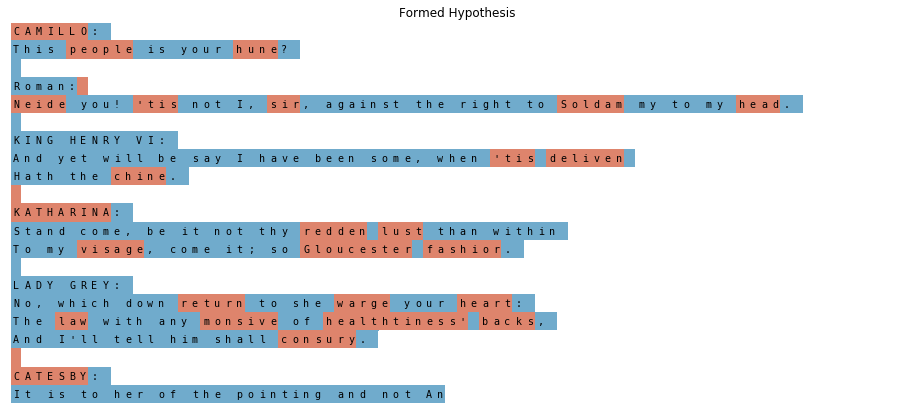

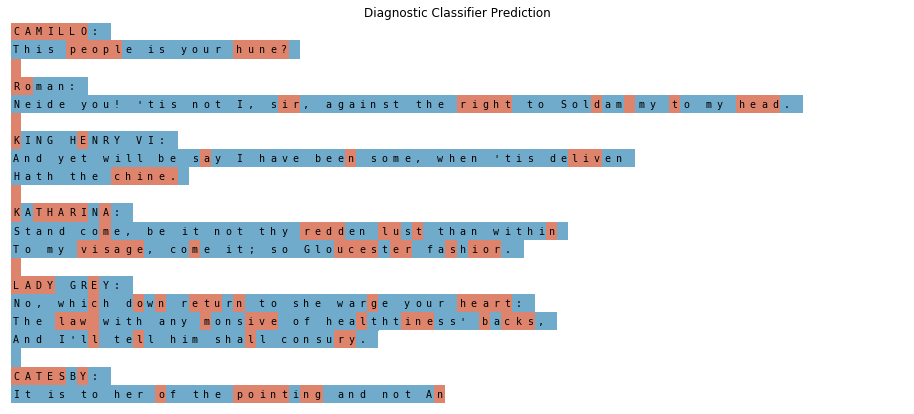

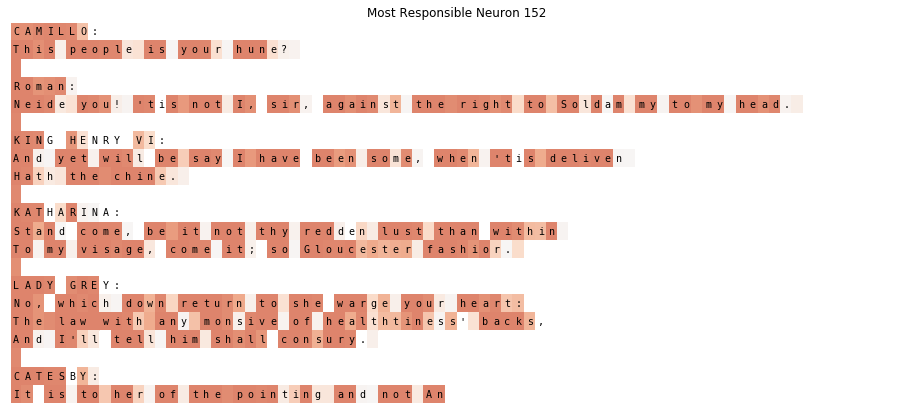

Hypothesis: Nouns (normal)
acc:       0.805263157895
prec:      0.716166281755
recall:    0.625790394188
f1-score:  0.667935094773
pearsonr:  0.533472093369


part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'


213


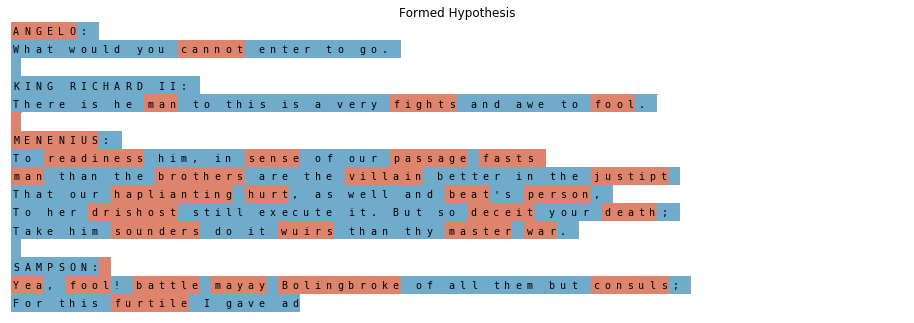

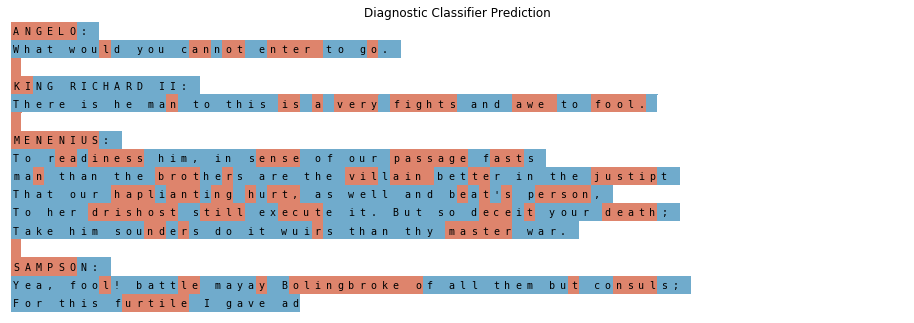

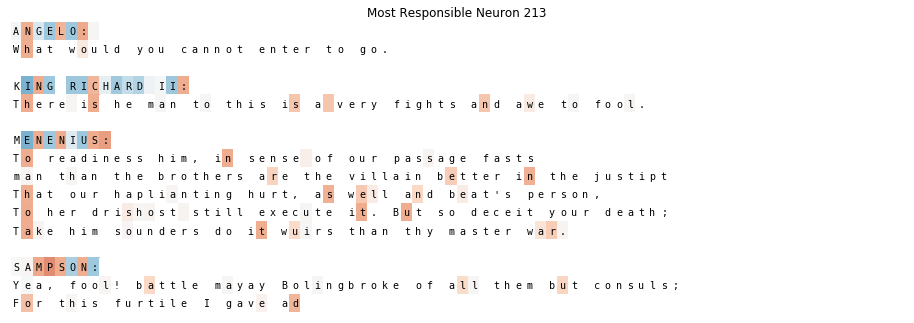

Hypothesis: Nouns (balanced)
acc:       0.8004
prec:      0.683585313175
recall:    0.754469606675
f1-score:  0.717280453258
pearsonr:  0.565246987144


part of speech not recognized: 'grjyy'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'grjyy'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recogn

191


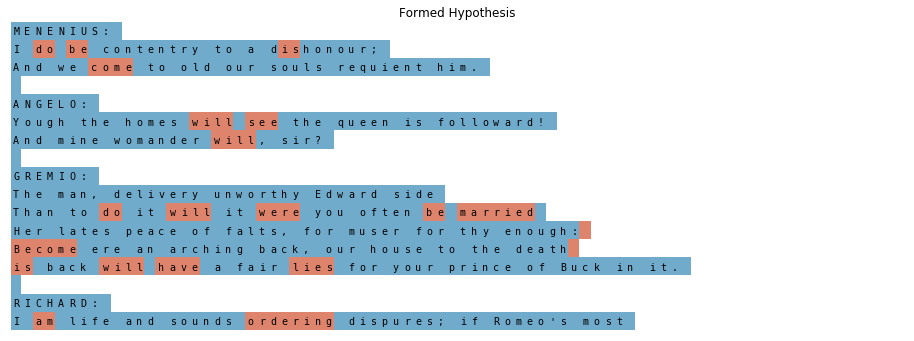

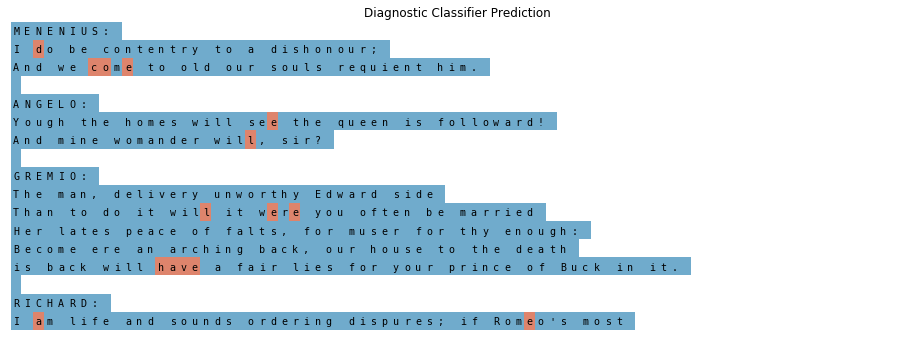

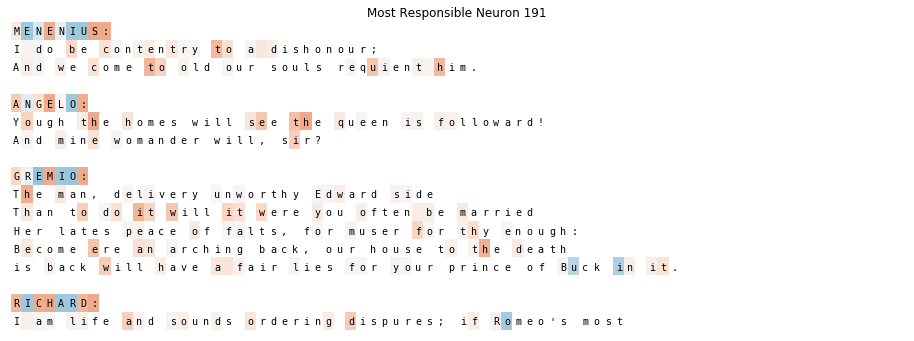

Hypothesis: Verbs (normal)
acc:       0.890168421053
prec:      0.680884063591
recall:    0.285528455285
f1-score:  0.402337037461
pearsonr:  0.393544814873


part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'grjyy'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'


475


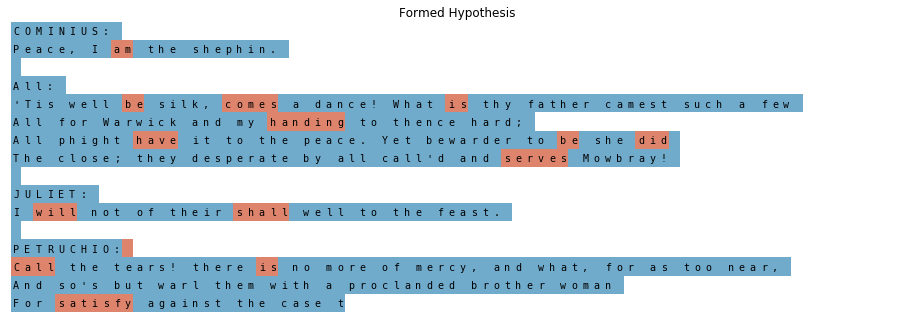

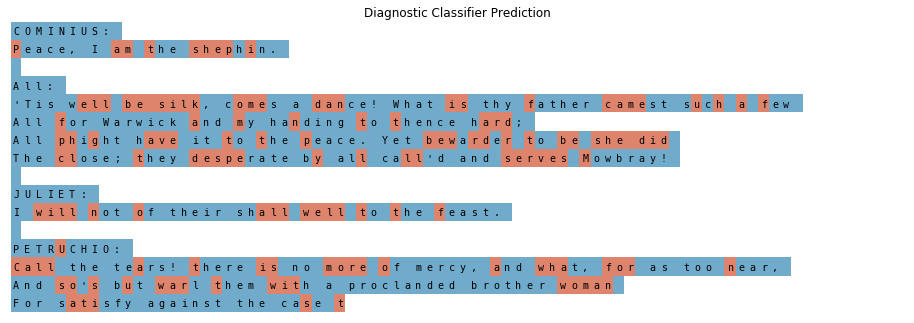

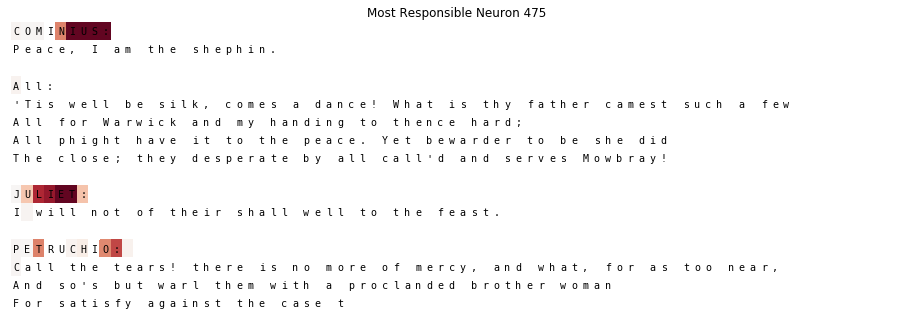

Hypothesis: Verbs (balanced)
acc:       0.74
prec:      0.263017356475
recall:    0.667796610169
f1-score:  0.377394636015
pearsonr:  0.293996746058
MODEL:  linux_gru
201


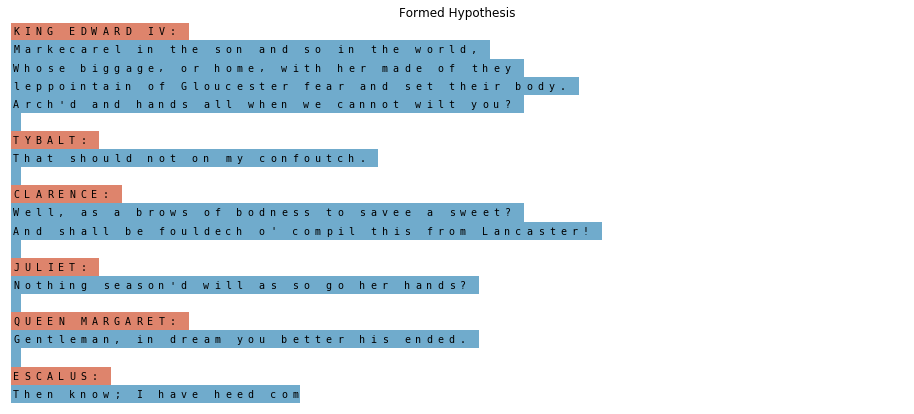

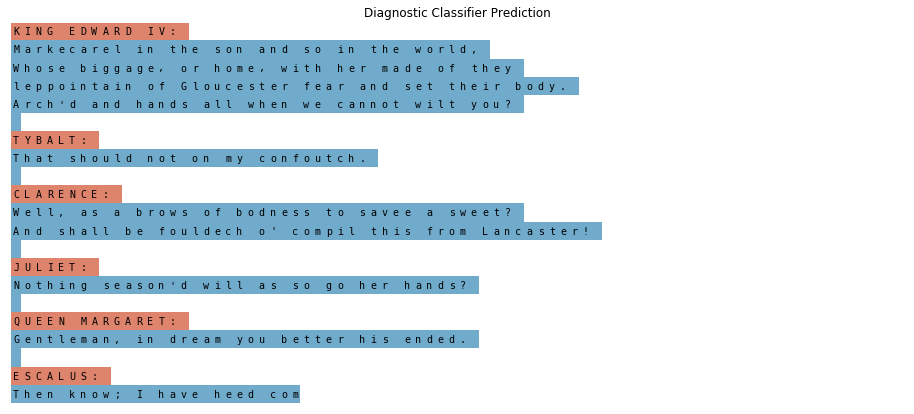

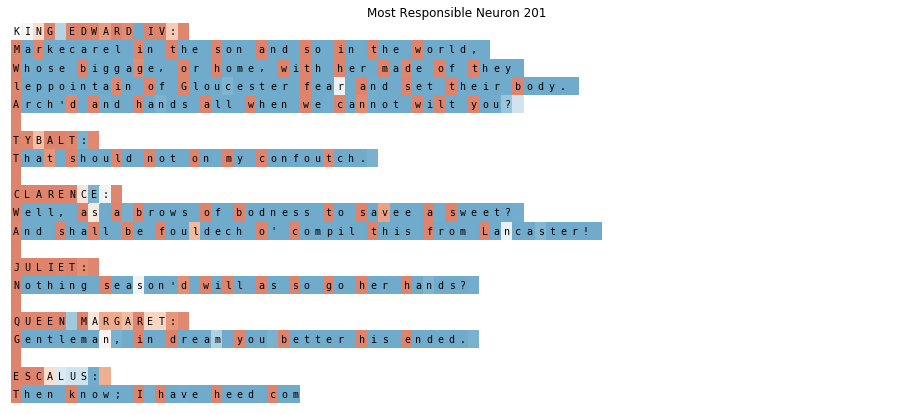

Hypothesis: Capitalized Words (normal)
acc:       0.996821052632
prec:      0.971520342612
recall:    0.996048298573
f1-score:  0.983631436314
pearsonr:  0.981964916373
38


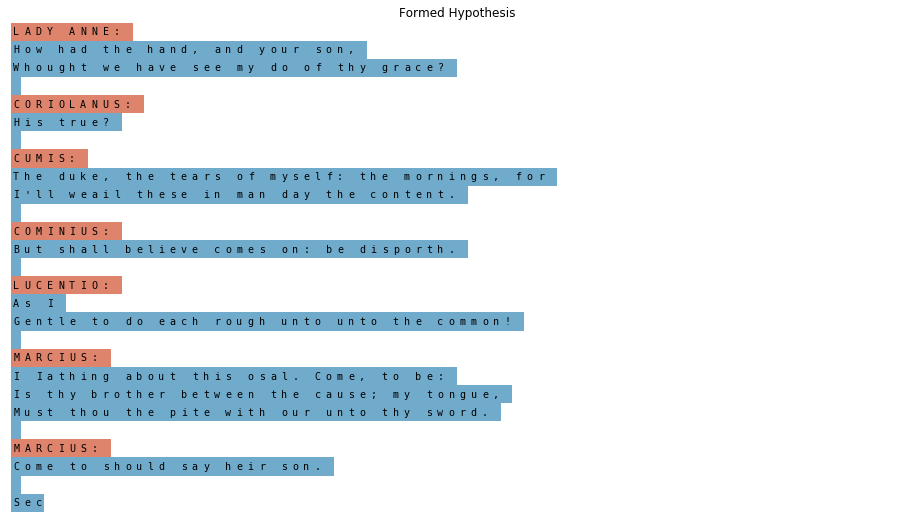

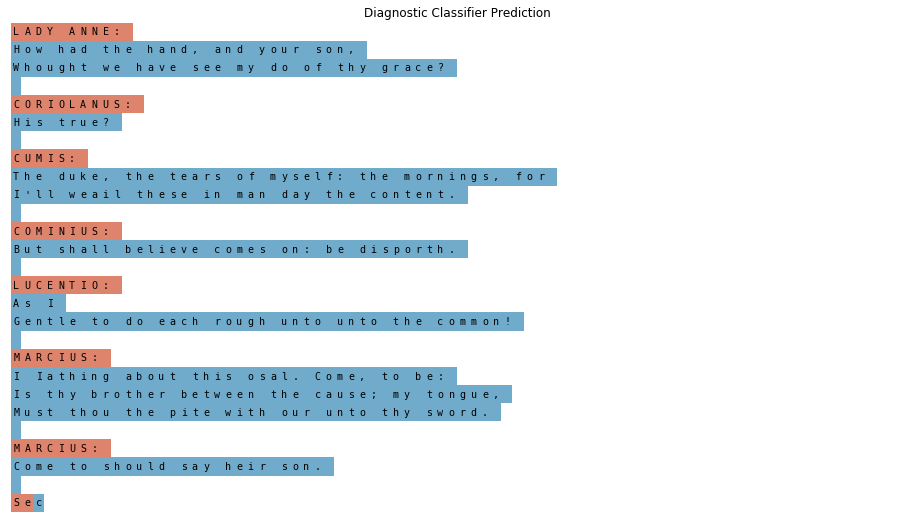

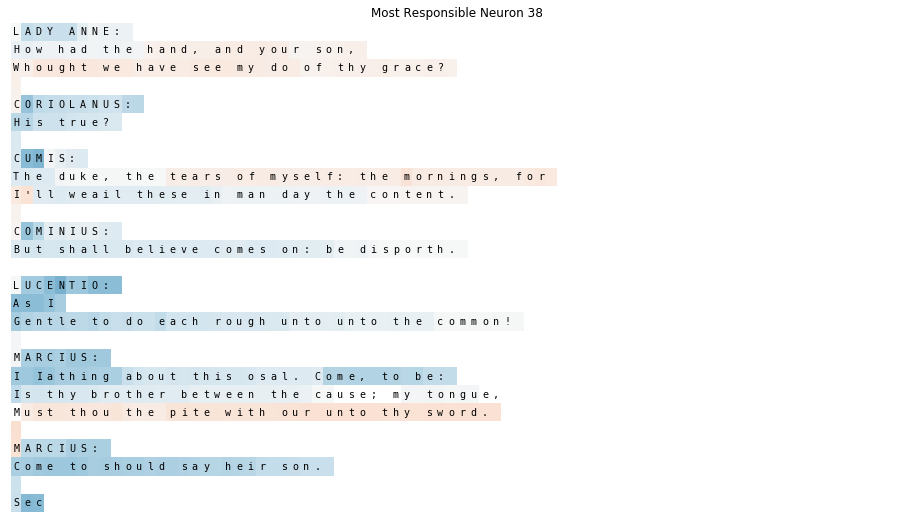

Hypothesis: Capitalized Words (balanced)
acc:       0.9964
prec:      0.972307692308
recall:    1.0
f1-score:  0.985959438378
pearsonr:  0.984022829938


part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc7 in position 340: invalid continuation byte

In [17]:
for model_name, model in [('shake_lstm', model_lstm), ('shake_gru', model_gru)]:
    print("MODEL: ", model_name)
    
    full_test(model, hypothesis_capswords, 'Capitalized Words',
              train_len=95, test_len=5, ex_name='{}_capswords'.format(model_name))
    full_test(model, hypothesis_nouns, 'Nouns',
              train_len=95, test_len=5, ex_name='{}_nouns'.format(model_name))
    full_test(model, hypothesis_verbs, 'Verbs',
              train_len=95, test_len=5, ex_name='{}_verbs'.format(model_name))